<a href="https://colab.research.google.com/github/spetznick/applied-gpu-programming/blob/colab-s/assignment-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Assignment 2
Explain how the program is compiled and run.
For a vector length of N:

1. How many floating operations are being performed in your vector add kernel?
2. How many global memory reads are being performed by your kernel?

For a vector length of 512:

1. Explain how many CUDA threads and thread blocks you used.
2. Profile your program with Nvidia Nsight. What Achieved Occupancy did you get? You might find https://docs.nvidia.com/nsight-compute/NsightComputeCli/index.html#nvprof-metric-comparison
Links to an external site. useful.

Now increase the vector length to 262140:

1. Did your program still work? If not, what changes did you make?
2. Explain how many CUDA threads and thread blocks you used.
Profile your program with Nvidia Nsight. What Achieved Occupancy do you get now?

Further increase the vector length (try 6-10 different vector length), plot a stacked bar chart showing the breakdown of time including (1) data copy from host to device (2) the CUDA kernel (3) data copy from device to host. For this, you will need to add simple CPU timers to your code regions.





In [1]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Wed Nov 13 13:38:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              13W /  7


## First exercise of the second assignment


In [79]:
%%writefile hw2_ex1.cu
#include <stdio.h>
#include <stdio.h>
#include <sys/time.h>

#define DataType double

__global__ void vecAdd(DataType *in1, DataType *in2, DataType *out, int len) {
  int myID = blockIdx.x*blockDim.x + threadIdx.x;
  if (myID < len) {
    out[myID] = in1[myID] + in2[myID];
  }
}

// Function to calculate mean and standard deviation of an array of floats
void calculateMeanAndStdDev(float *times, int numRuns, float *mean, float *stdDev) {
  float sum = 0.0;
  for (int i = 0; i < numRuns; i++) {
    sum += times[i];
  }
  *mean = sum / numRuns;

  float variance = 0.0;
  for (int i = 0; i < numRuns; i++) {
    variance += (times[i] - *mean) * (times[i] - *mean);
  }
  *stdDev = sqrt(variance / numRuns);
}

int main(int argc, char **argv) {
  if (argc < 4) {
    printf("Please provide vector length, thread number, and number of runs as command-line arguments.\n");
    return 1;
  }

  int inputLength = strtol(argv[1], NULL, 10);
  int numThreadsPerBlock = strtol(argv[2], NULL, 10);
  int numRuns = strtol(argv[3], NULL, 10);

  int size = inputLength * sizeof(DataType);
  DataType *hostInput1 = (DataType *)malloc(size);
  DataType *hostInput2 = (DataType *)malloc(size);
  DataType *hostOutput = (DataType *)malloc(size);
  DataType *resultRef = (DataType *)malloc(size);

  // Initialize host inputs with random values
  srand(time(NULL));
  for (int i = 0; i < inputLength; ++i) {
    hostInput1[i] = (DataType)rand() / RAND_MAX;
    hostInput2[i] = (DataType)rand() / RAND_MAX;
  }

  DataType *deviceInput1, *deviceInput2, *deviceOutput;
  cudaMalloc(&deviceInput1, size);
  cudaMalloc(&deviceInput2, size);
  cudaMalloc(&deviceOutput, size);

  cudaMemcpy(deviceInput1, hostInput1, size, cudaMemcpyHostToDevice);
  cudaMemcpy(deviceInput2, hostInput2, size, cudaMemcpyHostToDevice);

  dim3 blockDim(numThreadsPerBlock);
  dim3 gridDim((inputLength + blockDim.x - 1) / blockDim.x);

  // CUDA events for timing
  cudaEvent_t start, stop;
  cudaEventCreate(&start);
  cudaEventCreate(&stop);

  float *times = (float *)malloc(numRuns * sizeof(float));

  for (int run = 0; run < numRuns; run++) {
    cudaEventRecord(start, 0);

    // Launch the kernel
    vecAdd<<<gridDim, blockDim>>>(deviceInput1, deviceInput2, deviceOutput, inputLength);

    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);

    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);
    times[run] = milliseconds;
  }

  float mean, stdDev;
  calculateMeanAndStdDev(times, numRuns, &mean, &stdDev);

  printf("Input length %d, (numBlocks, numThreadsPerBlock) = (%d, %d).\n", inputLength, gridDim.x, blockDim.x);
  printf("Average kernel execution time of %d runs: %.4f +- %.4f ms\n", numRuns, mean, stdDev);

  // Error checking and final result comparison
  cudaMemcpy(hostOutput, deviceOutput, size, cudaMemcpyDeviceToHost);

  for (int i = 0; i < inputLength; ++i) {
    resultRef[i] = hostInput1[i] + hostInput2[i];
  }
  for (int i = 0; i < inputLength; ++i) {
    if (abs(resultRef[i] - hostOutput[i]) > 1e-5) {
      printf("Addition wrong at %i: (cpu, gpu) = (%.3f, %.3f)\n", i, resultRef[i], hostOutput[i]);
      break;
    }
  }

  cudaFree(deviceInput1);
  cudaFree(deviceInput2);
  cudaFree(deviceOutput);

  free(hostInput1);
  free(hostInput2);
  free(hostOutput);
  free(resultRef);
  free(times);

  cudaEventDestroy(start);
  cudaEventDestroy(stop);

  return 0;
}


Overwriting hw2_ex1.cu


In [87]:
%%writefile hw2_ex1.cu
#include <stdio.h>
#include <sys/time.h>

#define DataType double

__global__ void vecAdd(DataType *in1, DataType *in2, DataType *out, int len) {
  int myID = blockIdx.x * blockDim.x + threadIdx.x;
  if (myID < len) {
    out[myID] = in1[myID] + in2[myID];
  }
}

// Function to calculate mean and standard deviation of an array of floats
void calculateMeanAndStdDev(float *times, int numRuns, float *mean, float *stdDev) {
  float sum = 0.0;
  for (int i = 0; i < numRuns; i++) {
    sum += times[i];
  }
  *mean = sum / numRuns;

  float variance = 0.0;
  for (int i = 0; i < numRuns; i++) {
    variance += (times[i] - *mean) * (times[i] - *mean);
  }
  *stdDev = sqrt(variance / numRuns);
}

int main(int argc, char **argv) {
  if (argc < 4) {
    printf("Please provide vector length, thread number, and number of runs as command-line arguments.\n");
    return 1;
  }

  int inputLength = strtol(argv[1], NULL, 10);
  int numThreadsPerBlock = strtol(argv[2], NULL, 10);
  int numRuns = strtol(argv[3], NULL, 10);

  int size = inputLength * sizeof(DataType);
  DataType *hostInput1 = (DataType *)malloc(size);
  DataType *hostInput2 = (DataType *)malloc(size);
  DataType *hostOutput = (DataType *)malloc(size);
  DataType *resultRef = (DataType *)malloc(size);

  // Initialize host inputs with random values
  srand(time(NULL));
  for (int i = 0; i < inputLength; ++i) {
    hostInput1[i] = (DataType)rand() / RAND_MAX;
    hostInput2[i] = (DataType)rand() / RAND_MAX;
  }

  DataType *deviceInput1, *deviceInput2, *deviceOutput;
  cudaMalloc(&deviceInput1, size);
  cudaMalloc(&deviceInput2, size);
  cudaMalloc(&deviceOutput, size);

  dim3 blockDim(numThreadsPerBlock);
  dim3 gridDim((inputLength + blockDim.x - 1) / blockDim.x);
  printf("The input length is %d, (numBlocks, numThreadsPerBlock) = (%d, %d).\n", inputLength, gridDim.x, blockDim.x);

  // CUDA events for timing
  cudaEvent_t start, stop;
  cudaEventCreate(&start);
  cudaEventCreate(&stop);

  float *kernelTimes = (float *)malloc(numRuns * sizeof(float));
  float *copyToDeviceTimes = (float *)malloc(numRuns * sizeof(float));
  float *copyToHostTimes = (float *)malloc(numRuns * sizeof(float));

  for (int run = 0; run < numRuns; run++) {
    // Time data copy to device
    cudaEventRecord(start);
    cudaMemcpy(deviceInput1, hostInput1, size, cudaMemcpyHostToDevice);
    cudaMemcpy(deviceInput2, hostInput2, size, cudaMemcpyHostToDevice);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&copyToDeviceTimes[run], start, stop);

    // Time kernel execution
    cudaEventRecord(start);
    vecAdd<<<gridDim, blockDim>>>(deviceInput1, deviceInput2, deviceOutput, inputLength);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&kernelTimes[run], start, stop);

    // Time data copy back to host
    cudaEventRecord(start);
    cudaMemcpy(hostOutput, deviceOutput, size, cudaMemcpyDeviceToHost);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&copyToHostTimes[run], start, stop);
  }

  float meanKernelTime, stdDevKernelTime;
  float meanCopyToDeviceTime, stdDevCopyToDeviceTime;
  float meanCopyToHostTime, stdDevCopyToHostTime;

  calculateMeanAndStdDev(kernelTimes, numRuns, &meanKernelTime, &stdDevKernelTime);
  calculateMeanAndStdDev(copyToDeviceTimes, numRuns, &meanCopyToDeviceTime, &stdDevCopyToDeviceTime);
  calculateMeanAndStdDev(copyToHostTimes, numRuns, &meanCopyToHostTime, &stdDevCopyToHostTime);

  printf("Input length %d, (numBlocks, numThreadsPerBlock) = (%d, %d).\n", inputLength, gridDim.x, blockDim.x);
  printf("Average kernel execution time of %d runs: %.4f +- %.4f ms\n", numRuns, meanKernelTime, stdDevKernelTime);
  printf("Average time for data copy to device:     %.4f +- %.4f ms\n", meanCopyToDeviceTime, stdDevCopyToDeviceTime);
  printf("Average time for data copy to host:       %.4f +- %.4f ms\n", meanCopyToHostTime, stdDevCopyToHostTime);

  // Error checking and final result comparison
  for (int i = 0; i < inputLength; ++i) {
    resultRef[i] = hostInput1[i] + hostInput2[i];
  }
  for (int i = 0; i < inputLength; ++i) {
    if (abs(resultRef[i] - hostOutput[i]) > 1e-5) {
      printf("Addition wrong at %i: (cpu, gpu) = (%.3f, %.3f)\n", i, resultRef[i], hostOutput[i]);
      break;
    }
  }

  cudaFree(deviceInput1);
  cudaFree(deviceInput2);
  cudaFree(deviceOutput);

  free(hostInput1);
  free(hostInput2);
  free(hostOutput);
  free(resultRef);
  free(kernelTimes);
  free(copyToDeviceTimes);
  free(copyToHostTimes);

  cudaEventDestroy(start);
  cudaEventDestroy(stop);

  return 0;
}


Overwriting hw2_ex1.cu


## We compile the saved cuda code using nvcc compiler

In [88]:
!nvcc hw2_ex1.cu -o hw2_ex1
!ls


hw2_ex1  hw2_ex1.cu  sample_data  vectorAdd.cu


## Finally, we execute the binary of the compiled code

In [89]:
# !./hw2_ex1 10 256
# !./hw2_ex1 10 512
!./hw2_ex1 512 256 10
!./hw2_ex1 512 512 10
!./hw2_ex1 512 1024 10
# !./hw2_ex1 10000 256
# !./hw2_ex1 10000 512
# !./hw2_ex1 10000 1024
!./hw2_ex1 100000 256 10
!./hw2_ex1 100000 512 10
!./hw2_ex1 100000 1024 10

The input length is 512, (numBlocks, numThreadsPerBlock) = (2, 256).
Input length 512, (numBlocks, numThreadsPerBlock) = (2, 256).
Average kernel execution time of 10 runs: 0.0287 +- 0.0611 ms
Average time for data copy to device:     0.0257 +- 0.0088 ms
Average time for data copy to host:       0.0170 +- 0.0067 ms
The input length is 512, (numBlocks, numThreadsPerBlock) = (1, 512).
Input length 512, (numBlocks, numThreadsPerBlock) = (1, 512).
Average kernel execution time of 10 runs: 0.0292 +- 0.0626 ms
Average time for data copy to device:     0.0214 +- 0.0035 ms
Average time for data copy to host:       0.0140 +- 0.0026 ms
The input length is 512, (numBlocks, numThreadsPerBlock) = (1, 1024).
Input length 512, (numBlocks, numThreadsPerBlock) = (1, 1024).
Average kernel execution time of 10 runs: 0.0226 +- 0.0472 ms
Average time for data copy to device:     0.0208 +- 0.0065 ms
Average time for data copy to host:       0.0153 +- 0.0035 ms
The input length is 100000, (numBlocks, numThre

In [71]:
# !./vectorAdd
# !nvprof --print-gpu-trace ./vectorAdd

## Vector length 512

In [72]:
!ncu --section "Occupancy" ./hw2_ex1 512 256 10

==PROF== Connected to process 15937 (/content/hw2_ex1)
The input length is 512, (numBlocks, numThreadsPerBlock)=(1, 1024).
==PROF== Profiling "vecAdd" - 0: 0%....50%....100% - 1 pass
Kernel execution time: 244.9588 ms
==PROF== Disconnected from process 15937
[15937] hw2_ex1@127.0.0.1
  vecAdd(double *, double *, double *, int) (1, 1, 1)x(1024, 1, 1), Context 1, Stream 7, Device 0, CC 7.5
    Section: Occupancy
    ------------------------------- ----------- ------------
    Metric Name                     Metric Unit Metric Value
    ------------------------------- ----------- ------------
    Block Limit SM                        block           16
    Block Limit Registers                 block            4
    Block Limit Shared Mem                block           16
    Block Limit Warps                     block            1
    Theoretical Active Warps per SM        warp           32
    Theoretical Occupancy                     %          100
    Achieved Occupancy               

## Vector length 262140

In [74]:
!ncu --section "Occupancy" ./hw2_ex1 262140 256 10

The input length is 262140, (numBlocks, numThreadsPerBlock)=(256, 1024).
Kernel execution time: 0.1649 ms
==PROF== Connected to process 16684 (/content/hw2_ex1)
The input length is 262140, (numBlocks, numThreadsPerBlock)=(256, 1024).
==PROF== Profiling "vecAdd" - 0: 0%....50%....100% - 1 pass
Kernel execution time: 231.3725 ms
==PROF== Disconnected from process 16684
[16684] hw2_ex1@127.0.0.1
  vecAdd(double *, double *, double *, int) (256, 1, 1)x(1024, 1, 1), Context 1, Stream 7, Device 0, CC 7.5
    Section: Occupancy
    ------------------------------- ----------- ------------
    Metric Name                     Metric Unit Metric Value
    ------------------------------- ----------- ------------
    Block Limit SM                        block           16
    Block Limit Registers                 block            4
    Block Limit Shared Mem                block           16
    Block Limit Warps                     block            1
    Theoretical Active Warps per SM        war

## Experiment with other sizes

In [95]:
# !./hw2_ex1 100000 256 10
# !./hw2_ex1 1000000 256 10
# !./hw2_ex1 10000000 256 10
# !./hw2_ex1 100000000 256 10
!./hw2_ex1 999999999 256 10
!./hw2_ex1 1000000000 256 10
!./hw2_ex1 10000000000 256 10

   Input Length  Kernel Execution Time (ms)  Copy to Device Time (ms)  \
0        100000                      0.0332                    0.4653   
1       1000000                      0.1134                    3.2890   
2       5000000                      0.4788                   16.9438   
3      10000000                      0.9397                   34.2606   
4      50000000                      4.5879                  171.6111   
5     100000000                      9.1720                  335.4579   

   Copy to Host Time (ms)  
0                  0.3076  
1                  2.1924  
2                 10.8117  
3                 21.0833  
4                104.4536  
5                207.1870  


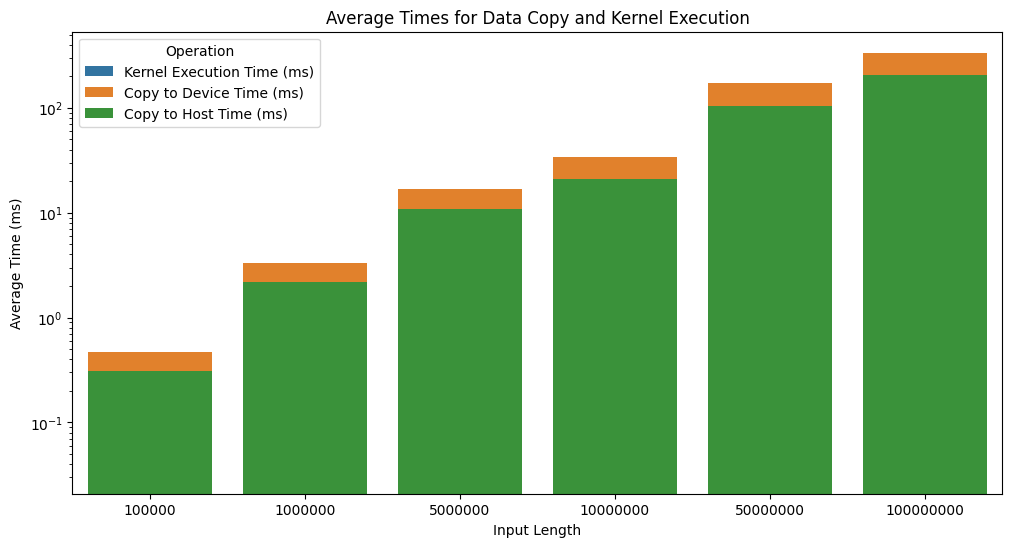

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import pandas as pd

def parse_results(results_str):
    """
    Parses the results of multiple test runs and returns a DataFrame.

    Args:
    - results_str (str): A string containing the test run output.

    Returns:
    - df (pd.DataFrame): A DataFrame containing the parsed results.
    """

    # Regex pattern to match each block of results for a single input length
    pattern = r"The input length is (\d+), \(numBlocks, numThreadsPerBlock\) = \(\d+, \d+\).\s*Input length \d+, \(numBlocks, numThreadsPerBlock\) = \(\d+, \d+\).\s*Average kernel execution time of \d+ runs: ([\d.]+) \+- [\d.]+ ms\s*Average time for data copy to device: +([\d.]+) \+- [\d.]+ ms\s*Average time for data copy to host: +([\d.]+) \+- [\d.]+ ms"

    # Use regex to find all matches in the string
    matches = re.findall(pattern, results_str)

    # Create a list to store the parsed data
    data = []

    # Parse each match and store as a dictionary
    for match in matches:
        input_length = int(match[0])
        kernel_time = float(match[1])
        copy_to_device_time = float(match[2])
        copy_to_host_time = float(match[3])

        # Append the parsed data to the list
        data.append({
            "Input Length": input_length,
            "Kernel Execution Time (ms)": kernel_time,
            "Copy to Device Time (ms)": copy_to_device_time,
            "Copy to Host Time (ms)": copy_to_host_time
        })

    # Convert the data list to a DataFrame
    df = pd.DataFrame(data)

    return df

# Example usage with the input printout string
results_str = """
The input length is 100000, (numBlocks, numThreadsPerBlock) = (391, 256).
Input length 100000, (numBlocks, numThreadsPerBlock) = (391, 256).
Average kernel execution time of 10 runs: 0.0332 +- 0.0546 ms
Average time for data copy to device:     0.4653 +- 0.0313 ms
Average time for data copy to host:       0.3076 +- 0.1151 ms
The input length is 1000000, (numBlocks, numThreadsPerBlock) = (3907, 256).
Input length 1000000, (numBlocks, numThreadsPerBlock) = (3907, 256).
Average kernel execution time of 10 runs: 0.1134 +- 0.0486 ms
Average time for data copy to device:     3.2890 +- 0.1589 ms
Average time for data copy to host:       2.1924 +- 1.2510 ms
The input length is 5000000, (numBlocks, numThreadsPerBlock) = (19532, 256).
Input length 5000000, (numBlocks, numThreadsPerBlock) = (19532, 256).
Average kernel execution time of 10 runs: 0.4788 +- 0.0516 ms
Average time for data copy to device:     16.9438 +- 0.4962 ms
Average time for data copy to host:       10.8117 +- 6.7098 ms
The input length is 10000000, (numBlocks, numThreadsPerBlock) = (39063, 256).
Input length 10000000, (numBlocks, numThreadsPerBlock) = (39063, 256).
Average kernel execution time of 10 runs: 0.9397 +- 0.0546 ms
Average time for data copy to device:     34.2606 +- 0.9204 ms
Average time for data copy to host:       21.0833 +- 11.8544 ms
The input length is 50000000, (numBlocks, numThreadsPerBlock) = (195313, 256).
Input length 50000000, (numBlocks, numThreadsPerBlock) = (195313, 256).
Average kernel execution time of 10 runs: 4.5879 +- 0.0704 ms
Average time for data copy to device:     171.6111 +- 8.4352 ms
Average time for data copy to host:       104.4536 +- 58.5639 ms
The input length is 100000000, (numBlocks, numThreadsPerBlock) = (390625, 256).
Input length 100000000, (numBlocks, numThreadsPerBlock) = (390625, 256).
Average kernel execution time of 10 runs: 9.1720 +- 0.0574 ms
Average time for data copy to device:     335.4579 +- 3.3210 ms
Average time for data copy to host:       207.1870 +- 119.9519 ms
"""

# Parse the results
df = parse_results(results_str)

# Print the resulting DataFrame
print(df)

# # Data preparation
# data = {
#     "Input Length": [100000, 1000000, 5000000, 10000000, 50000000, 100000000],
#     "Kernel Execution Time (ms)": [0.0332, 0.1134, 0.4788, 0.9397, 4.5879, 9.1720],
#     "Copy to Device Time (ms)": [0.4653, 3.2890, 16.9438, 34.2606, 171.6111, 335.4579],
#     "Copy to Host Time (ms)": [0.3076, 2.1924, 10.8117, 21.0833, 104.4536, 207.1870]
# }

# # Convert the data into a pandas DataFrame
# df = pd.DataFrame(data)

# Reshape the DataFrame for a stacked bar plot
df_melted = df.melt(id_vars="Input Length",
                    value_vars=["Kernel Execution Time (ms)", "Copy to Device Time (ms)", "Copy to Host Time (ms)"],
                    var_name="Operation",
                    value_name="Time (ms)")

# Plotting the stacked bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x="Input Length", y="Time (ms)", hue="Operation", dodge=False)

# Adding plot details
plt.title("Average Times for Data Copy and Kernel Execution")
plt.xlabel("Input Length")
plt.ylabel("Average Time (ms)")
plt.yscale("log")  # Log scale can help better visualize the differences across large ranges
plt.legend(title="Operation", loc="upper left")

plt.show()
